In [36]:
# run-but-hide
import sys
sys.path.insert(0, "..")

In [37]:
import numpy as np
from elastipy import Search, query

They always say: *put the imports at the top!*


# git commit analytics

Below we use a lot of :link:`pandas` and plotting to get insight into the community of an open source project. 

To explore a repository of your choice move to `elastipy/examples/` and call:

```bash
python gitlogs.py <project-name> path/to/git-repo
```

If you are `cloning` a repository and are just interested in commits you can somewhat limit the size on disk with:

```bash
git clone <repo-url> --no-checkout
```

Replace the `<project-name>` with the name of the project and change the value below in the `notebook`:   

In [2]:
PROJECT = "pandas"

def search():
    return Search(f"elastipy-example-commits-{PROJECT}")

In [35]:
# run-but-hide
assert search().execute().total_hits

## activity

### commits per week

<AxesSubplot:xlabel='date'>

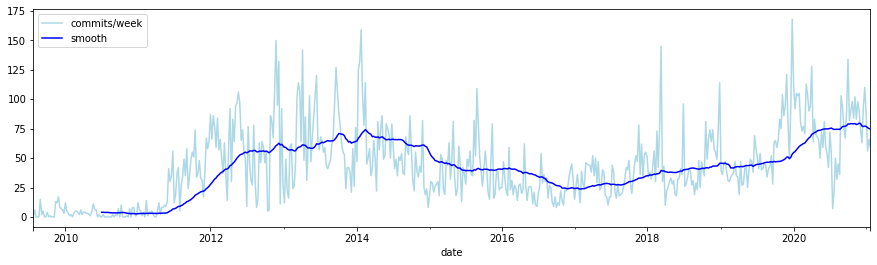

In [3]:
s = search()
agg = s.agg_date_histogram("date", calendar_interval="week")
df = agg.execute().df(to_index=True)
df["commits/week"] = df.pop("date.doc_count")
df["smooth"] = df.rolling(window=50).mean()
df.plot(figsize=(15,4), color=["lightblue", "blue"])

### additions/deletions per week

<AxesSubplot:xlabel='date'>

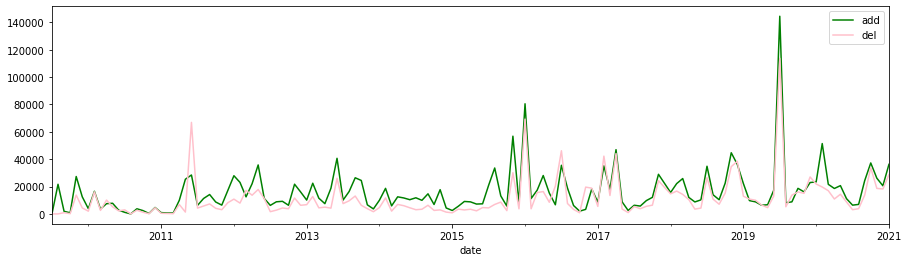

In [4]:
s = search()
agg = s.agg_date_histogram("date", calendar_interval="month")
agg.metric_sum("add", field="changes.additions")
agg.metric_sum("del", field="changes.deletions")
df = agg.execute().df(to_index=True, exclude="*doc_count")
#df = df.rolling(window=10).mean()[["add", "del"]]
df.plot.line(color=["green", "pink"], figsize=(15,4))

## authors

### top 3 authors per year

<AxesSubplot:xlabel='date'>

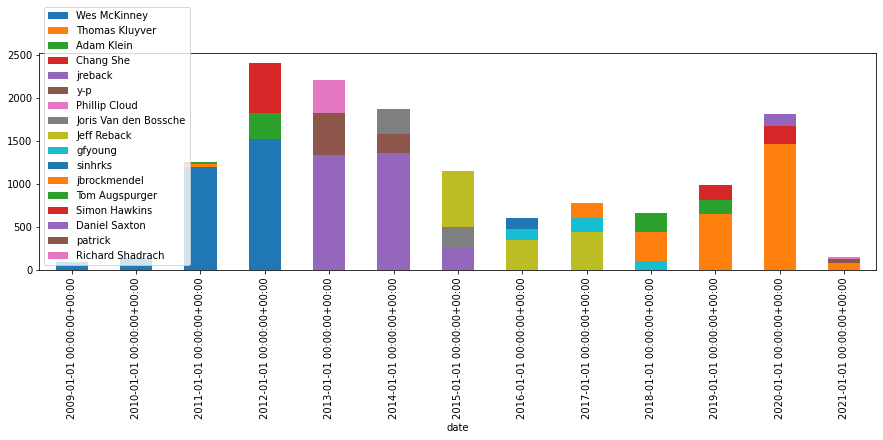

In [5]:
s = search()
agg = s.agg_date_histogram("date", calendar_interval="year")
agg = agg.agg_terms("author", field="author", size=3)
agg_top3_authors = agg
agg.execute().df(to_index=True, flat="author", exclude="*doc_count").plot.bar(figsize=(15,4), stacked=True)

#### commits of all top 3 authors  

<AxesSubplot:>

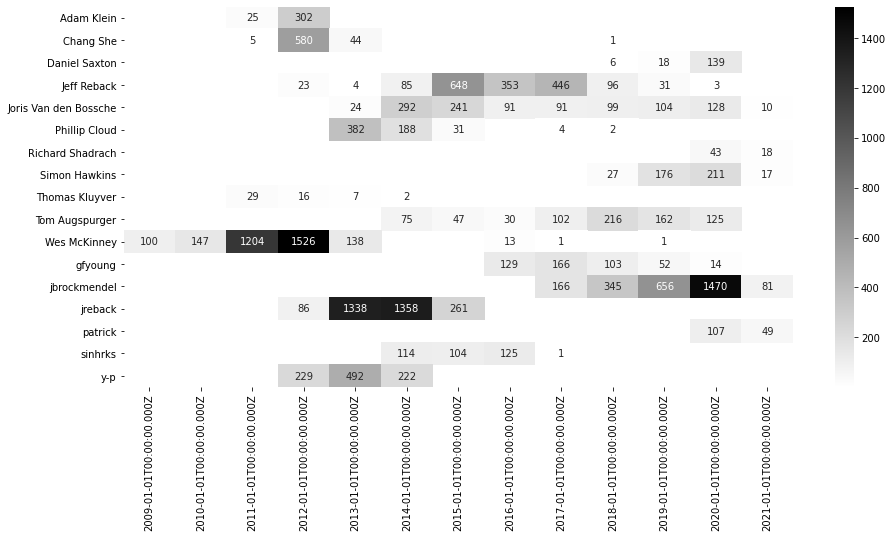

In [34]:
top_authors = set(k[1] for k in agg_top3_authors.keys())

s = search()
agg = s.agg_filters("author", filters={key: query.Term("author", key) for key in top_authors})
agg = agg.agg_date_histogram("date", calendar_interval="year")
agg.execute().plot.heatmap(
    sort=True, replace={0: np.nan},
    annot=True, fmt=".0f", figsize=(15, .6), cmap="gray_r"
)

### top 3 average-additions per author per year

<AxesSubplot:>

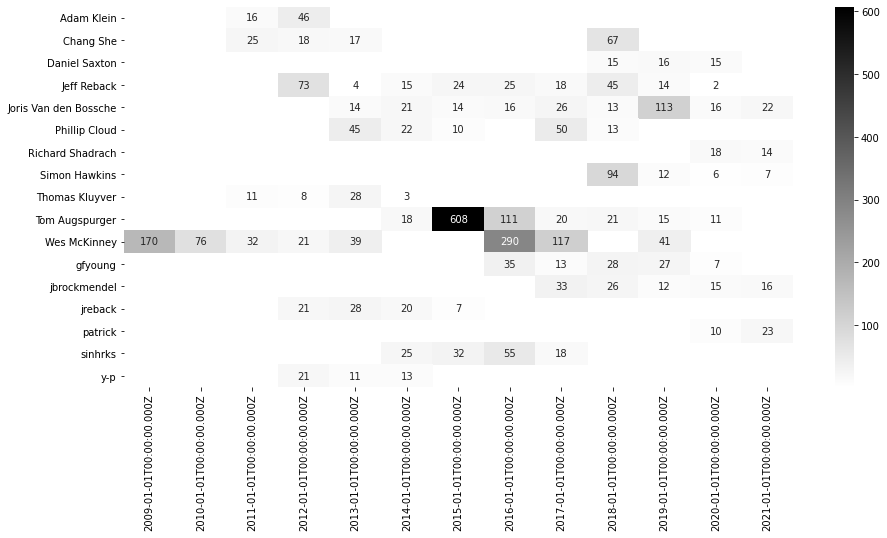

In [33]:
s = search()
agg = s.agg_filters("author", filters={key: query.Term("author", key) for key in top_authors})
agg = agg.agg_date_histogram("date", calendar_interval="year")
agg = agg.metric_avg("avg-add", field="changes.additions", return_self=True)
agg.execute().plot.heatmap(
    sort=True, replace={0: np.nan},
    annot=True, fmt=".0f", figsize=(15, .6), cmap="gray_r"
)

### number of authors per year

2504 authors at all


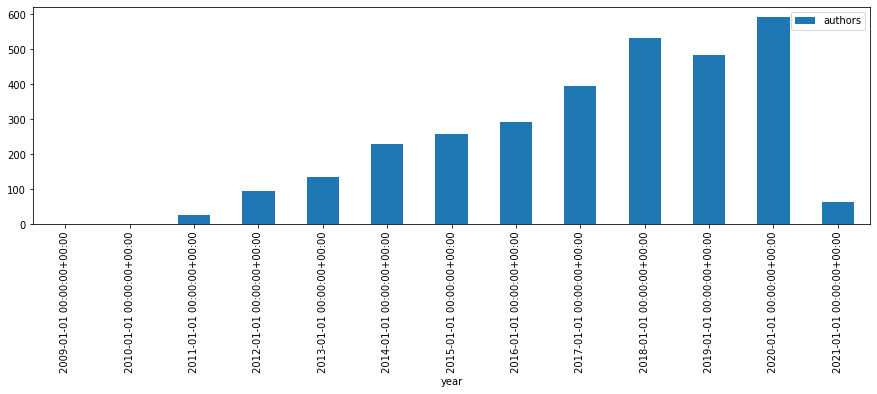

In [8]:
s = search()
global_authors = s.metric_cardinality(field="author", return_self=True)
agg = s.agg_date_histogram("year", calendar_interval="year")
agg = agg.metric_cardinality("authors", field="author")
agg.execute().plot.bar("year", "authors", figsize=(15, 4))
print(next(global_authors.values()), "authors at all")

---

## commit messages

### the first ten commit messages

In [9]:
s = search().sort("timestamp")
# s = s.range("timestamp", gte="2020")
for d in s.execute().documents:
    print(("-- %(timestamp)s %(hash)s\n%(message)s" % d).strip() + "\n")

-- 2009-07-31T15:07:16+00:00 9d0080576446de475d34b0dbb58389b15cd4f529
Initial directory structure.

git-svn-id: http://pandas.googlecode.com/svn/trunk@1 d5231056-7de3-11de-ac95-d976489f1ece

-- 2009-08-05T02:32:49+00:00 ec1a0a2a2571dc2c1c26612b374d4a66b22f0938
adding trunk

git-svn-id: http://pandas.googlecode.com/svn/trunk@2 d5231056-7de3-11de-ac95-d976489f1ece

-- 2009-08-05T02:33:13+00:00 1eeadf4e401647faa20911f531bc05c1872262ea
oops

git-svn-id: http://pandas.googlecode.com/svn/trunk@3 d5231056-7de3-11de-ac95-d976489f1ece

-- 2009-08-05T03:17:29+00:00 445114e1b20da8d4976c8d9050aa90c5bd508c54
added svn:ignore

git-svn-id: http://pandas.googlecode.com/svn/trunk@4 d5231056-7de3-11de-ac95-d976489f1ece

-- 2009-08-05T03:30:16+00:00 c6b236db73ff81007909be6406f0e484edc4a9eb
first commit with cleaned up code

git-svn-id: http://pandas.googlecode.com/svn/trunk@5 d5231056-7de3-11de-ac95-d976489f1ece

-- 2009-08-05T03:40:05+00:00 c8efebf2bfbe6a1efc732679ad3cf2d06d795c3f
minor edit

git-svn-id

### significant terms by year

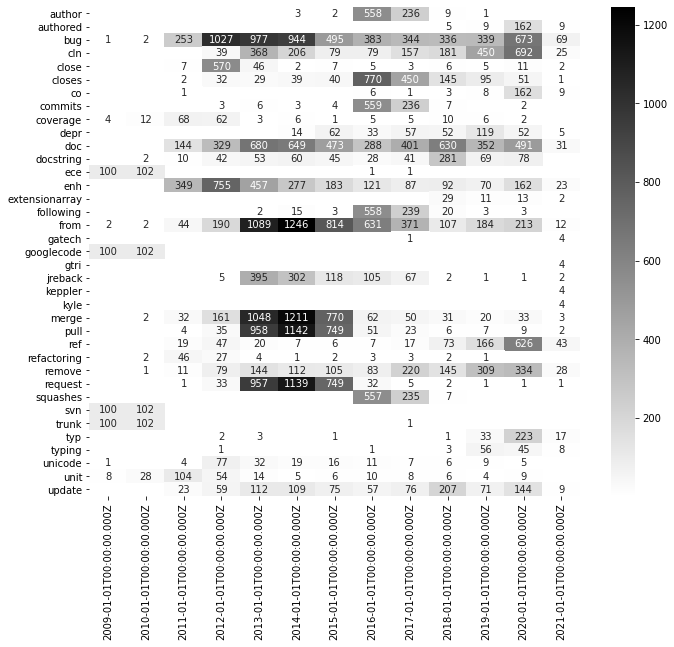

In [32]:
def significant_terms_by_year(s, field, size=4, shard_size=100):
    agg = s.copy().agg_date_histogram("year", calendar_interval="year")
    agg = agg.agg_significant_terms(field=field, size=size, shard_size=shard_size)
    keywords = set(k[-1] for k in agg.execute().keys())

    agg = s.agg_date_histogram("date", calendar_interval="year")
    agg = agg.agg_filters("word", filters={key: query.Term(field, key) for key in keywords})
    agg.execute().plot.heatmap(
        sort=True, replace={0: np.nan},
        transpose=True, annot=True, fmt=".0f", figsize=(.3, .7), cmap="gray_r"
    )
    
significant_terms_by_year(search(), "message")

### significant terms by author

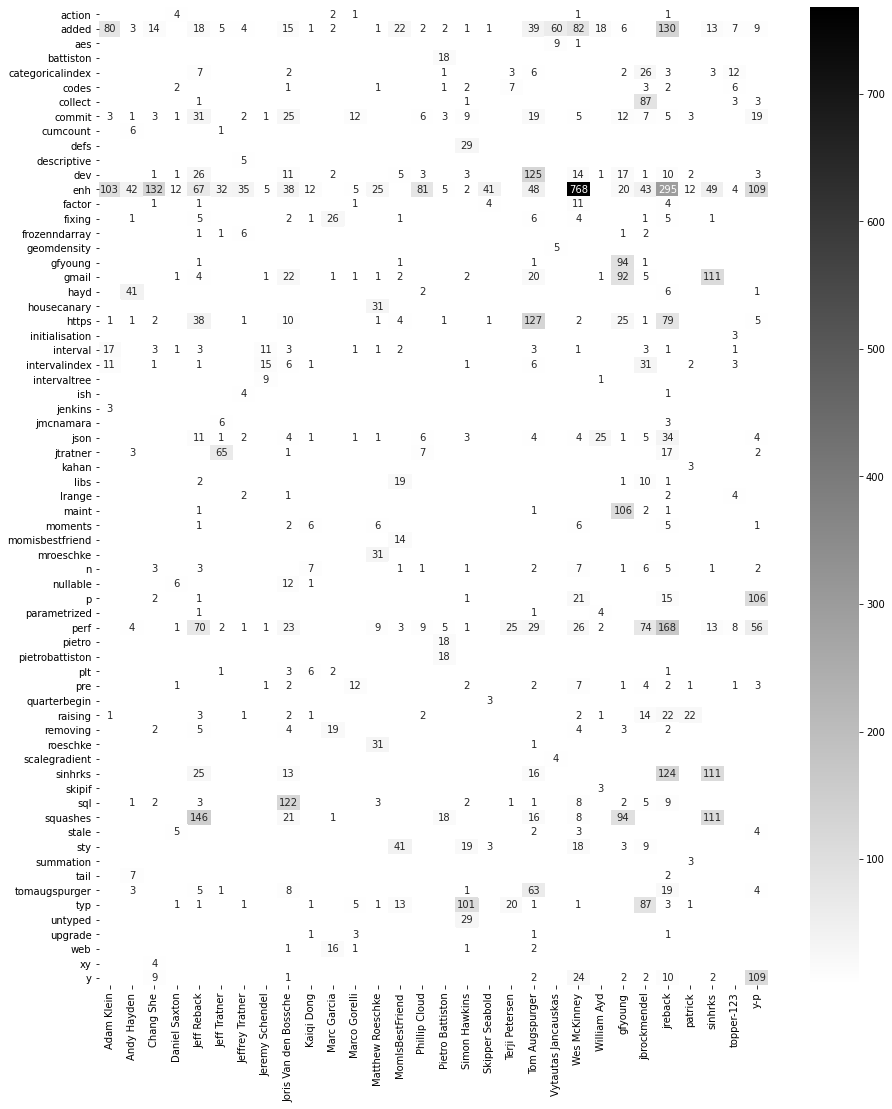

In [29]:
def significant_terms_by_terms(s, split_field, terms_field, split_size=30, size=3, shard_size=100):
    agg = s.copy().agg_terms(split_field, field=split_field, size=split_size)
    agg = agg.agg_significant_terms("term", field=terms_field, size=size, shard_size=shard_size)
    df = agg.execute().df(include=["term", "term.doc_count"])
    
    # find max count of all significant terms
    df = df.groupby("term").max()
    # print(df.describe())
    
    # and drop everything above a high percentile 
    df = df[df < df.quantile(.8)].dropna()
    keywords = list(df.index)

    agg = s.agg_terms(split_field, field=split_field, size=split_size)
    agg = agg.agg_filters("term", filters={key: query.Term(terms_field, key) for key in keywords})
    agg.execute().plot.heatmap(
        sort=True, transpose=True, replace={0: np.nan}, 
        annot=True, fmt=".0f", figsize=(.23, .6), cmap="gray_r"
    )
    
significant_terms_by_terms(search(), "author", "message")

## files

### overall top 50 edited files per year

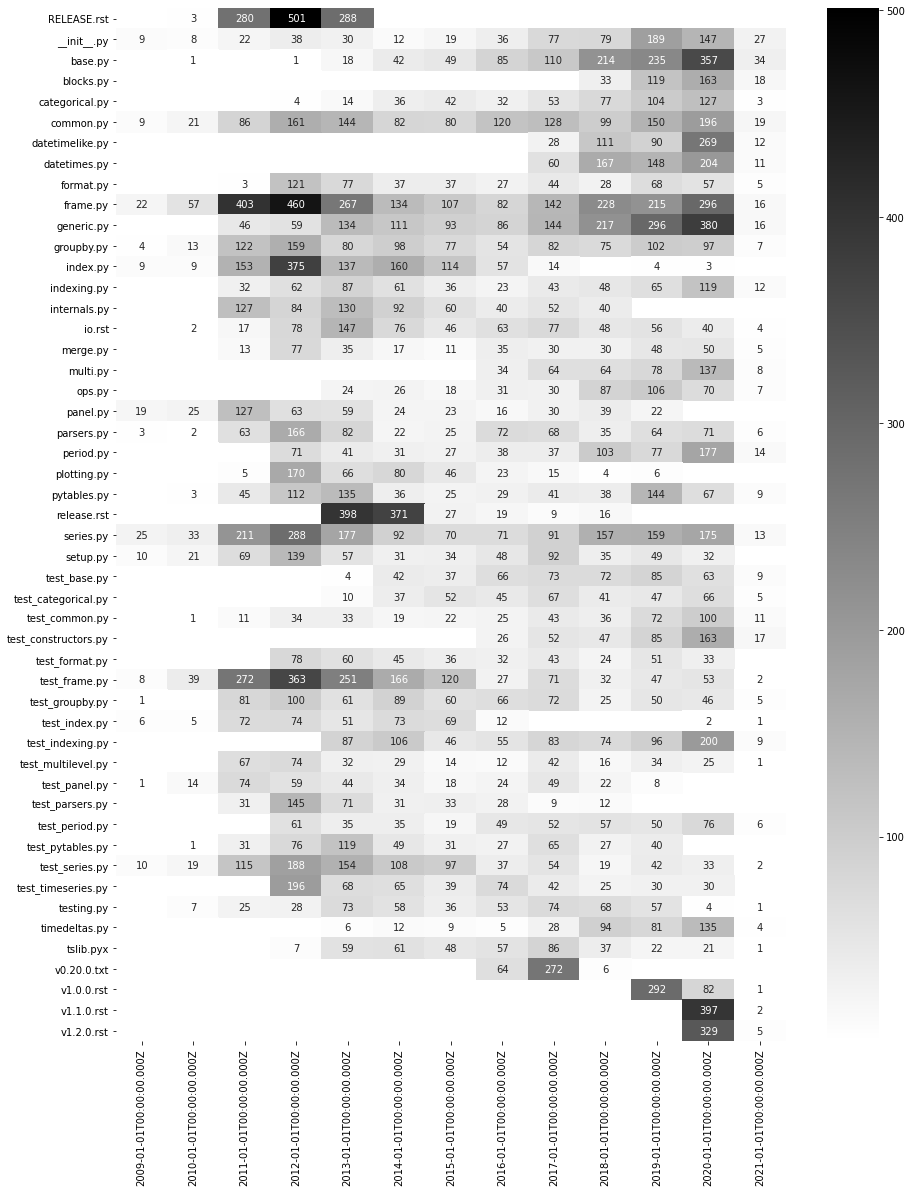

In [23]:
s = search()
agg = s.agg_terms(field="changes.file", size=50)
agg = agg.agg_date_histogram("date", calendar_interval="year")
df = agg.execute().plot.heatmap(
    sort=True, replace={0: np.nan},
    annot=True, fmt=".0f", figsize=(.3, 1.5), cmap="gray_r"
)

### significant changed files by year

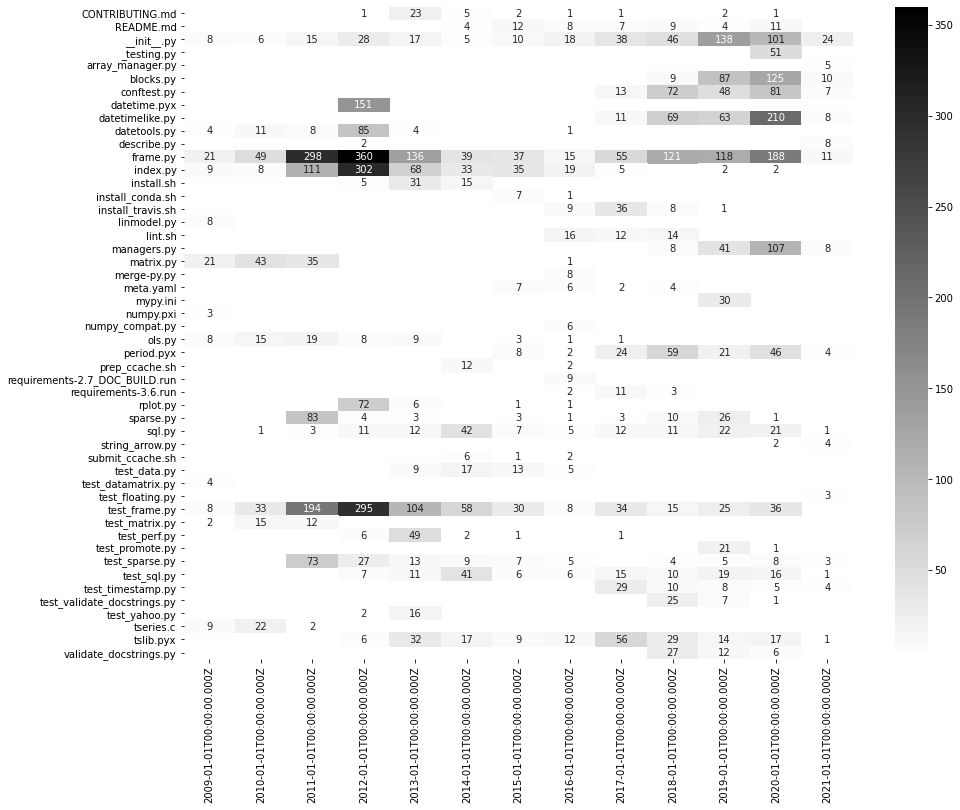

In [13]:
s = search().param(rest_total_hits_as_int=True)
# remove version specific files
s = ~s.query_string("changes.file: *.txt *.rst")
significant_terms_by_year(s, "changes.file")

### significant changed files by author

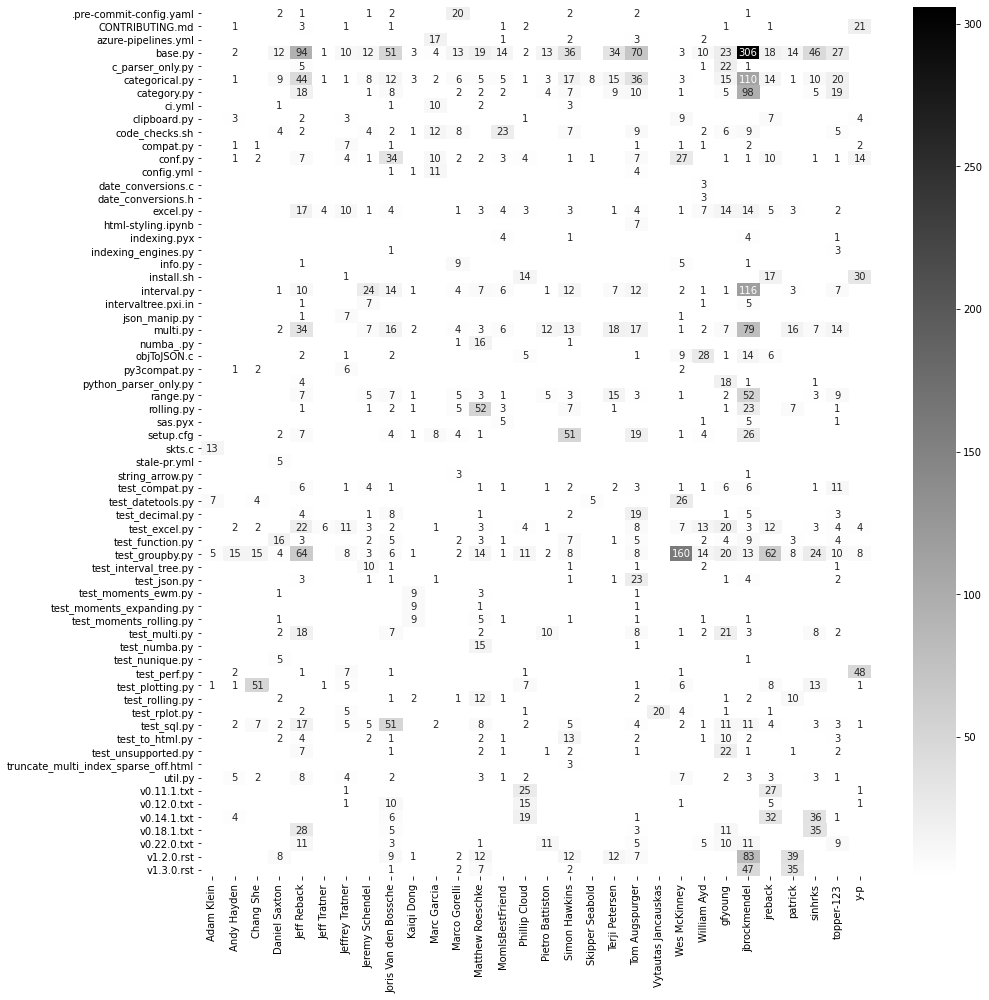

In [14]:
significant_terms_by_terms(search(), "author", "changes.file")

###  which files get edited together

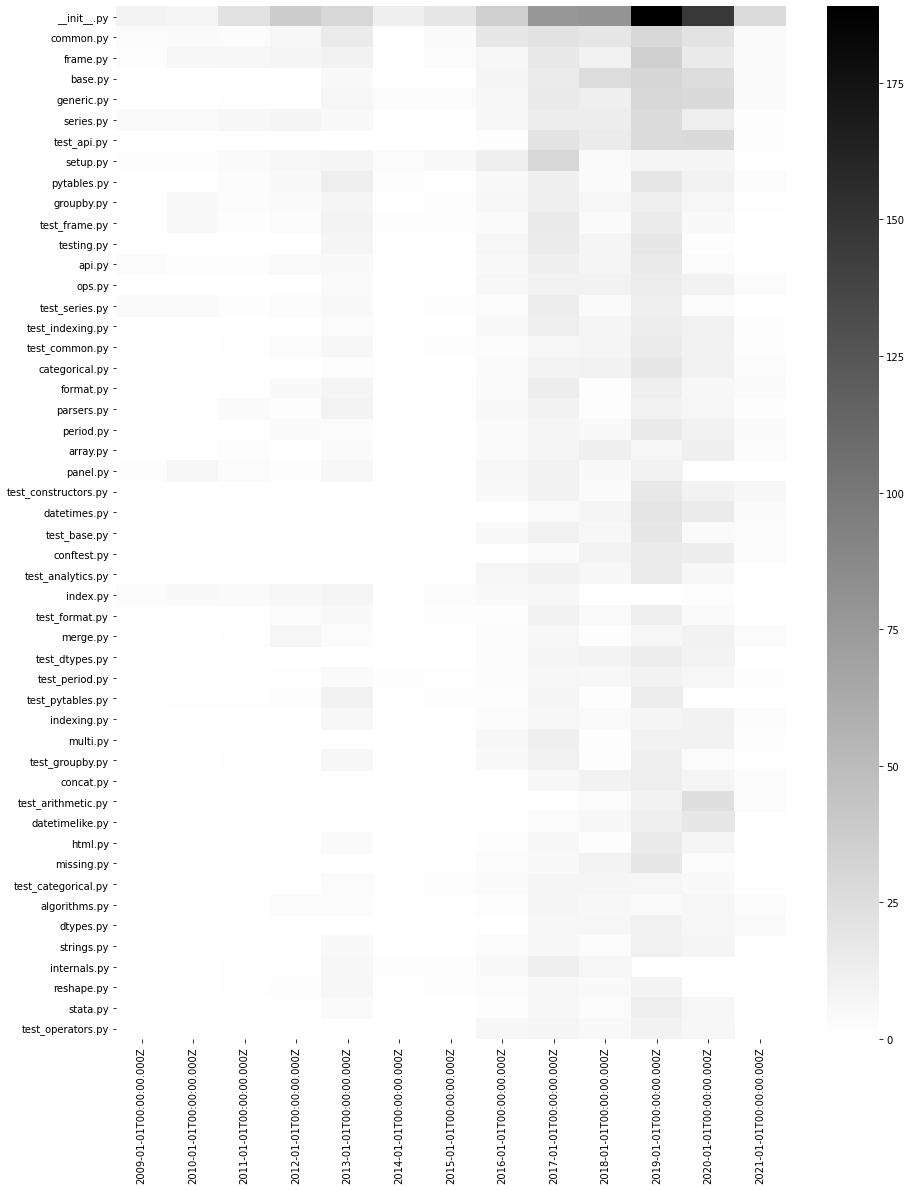

In [39]:
s = search()
s = s.query_string("changes.file: __init__.py")

agg = s.agg_terms(field="changes.file", size=50)
agg = agg.agg_date_histogram("date", calendar_interval="year")
try:
    agg.execute().plot.heatmap(figsize=(.3, 1.5), cmap="gray_r")
except ValueError:
    pass